# Cluster modellen
Unsupervised learning

In [10]:
import pyodbc
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Database connectie

In [11]:
# database name
DB = {
    'servername': '(local)\\SQLEXPRESS',
    'database': 'DEDS_DataWarehouse'}

In [12]:
export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')


# Create a cursor from the connection
export_cursor = export_conn.cursor()

# check if connection is successful, else throw an error
if export_conn:
    print("Connection with database is established")
else:
    print("Connection with database is not established")
    raise Exception("Connection with database is not established")

Connection with database is established


# Tabellen Inlezen
We hebben data nodig uit de volgende tabellen:
- Sales_branch

In [13]:
# Query om data uit de tabel te halen
query = "SELECT * FROM Sales_branch"

# Execute the query
result = export_cursor.execute(query)

# Fetch the data from the executed query
data_fetch = result.fetchall()

# converting to dataframe
sales_branch_columns = [column[0] for column in result.description]
sales_branch = pd.DataFrame.from_records(data_fetch, columns=sales_branch_columns)

# dropping columns that are not needed
sales_branch.drop(columns=['CURRENT_VALUE', 'LAST_UPDATED', 'SALES_BRANCH_SK', 'SALES_BRANCH_code', 'SALES_BRANCH_MAIN_ADDRESS_address', 'SALES_BRANCH_ADDRESS1_address', 'SALES_BRANCH_ADDRESS2_address'], inplace=True)

# display the data
sales_branch

,SALES_BRANCH_COUNTRY_CODE_country,SALES_BRANCH_REGION_region,SALES_BRANCH_CITY_city,SALES_BRANCH_POSTAL_ZONE_postal_zone
0,2,None,Hamburg,D-22529
1,2,None,München,D-81241
2,10,None,Kista,S-164 40
3,4,Alberta,Calgary,T2P 3Z0
4,4,Ontario,Toronto,M2M 4K8
5,3,Massachusetts,Boston,02133
6,3,Washington,Seattle,98139
7,3,California,Los Angeles,90072
8,3,Florida,Miami,33024
9,1,None,Lyon,F-69002


# Data Preprocessing
Null waarden vervangen en alles omzetten naar numerieke waarden

In [14]:
# filling the null values in the region column
sales_branch['SALES_BRANCH_REGION_region'].fillna('Unknown')

# converting the string columns to numerical values
sales_branch['SALES_BRANCH_REGION_region'] = sales_branch['SALES_BRANCH_REGION_region'].astype('category').cat.codes
sales_branch['SALES_BRANCH_CITY_city'] = sales_branch['SALES_BRANCH_CITY_city'].astype('category').cat.codes
sales_branch['SALES_BRANCH_POSTAL_ZONE_postal_zone'] = sales_branch['SALES_BRANCH_POSTAL_ZONE_postal_zone'].astype('category').cat.codes

sales_branch.head()

,SALES_BRANCH_COUNTRY_CODE_country,SALES_BRANCH_REGION_region,SALES_BRANCH_CITY_city,SALES_BRANCH_POSTAL_ZONE_postal_zone
0,2,-1,6,18
1,2,-1,16,19
2,10,-1,8,26
3,4,0,4,27
4,4,6,25,24


# KMeans
cluster model using KMeans

In [15]:
# Define a range of k values to try
ks = range(2, 21)

# Empty list to store the intra- and inter cluster distances
intra_distances = []
inter_distances = []

for k in ks:
    # Train een KMeans-model voor deze k
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(sales_branch)
    
    # Calculate the intra cluster distance as the sum of the distances of the samples to their closest cluster center. This is done by kmeans.inertia_
    intra_distance = kmeans.inertia_
    intra_distances.append(intra_distance)
    
    # Calculate the inter cluster distance as the mean distance between the cluster centers. this is done by pairwise_distances(kmeans.cluster_centers_)
    cluster_centers = kmeans.cluster_centers_
    inter_distance = np.mean(pairwise_distances(cluster_centers))
    inter_distances.append(inter_distance)

# Printing the results. Zip combines the lists so that we can iterate over them together
for k, intra, inter in zip(ks, intra_distances, inter_distances):
    print(f"For k={k}, intra-cluster distance={intra}, inter-cluster distance={inter}")

For k=2, intra-cluster distance=3765.4285714285725, inter-cluster distance=7.950099473129445
For k=3, intra-cluster distance=3015.924242424242, inter-cluster distance=11.010147644246246
For k=4, intra-cluster distance=2290.1357142857146, inter-cluster distance=13.617558167650145
For k=5, intra-cluster distance=2016.1166666666663, inter-cluster distance=14.423409609311648
For k=6, intra-cluster distance=1593.6428571428573, inter-cluster distance=15.28581343760272
For k=7, intra-cluster distance=1489.8833333333334, inter-cluster distance=16.086711641881838
For k=8, intra-cluster distance=1173.642857142857, inter-cluster distance=16.742569473231654
For k=9, intra-cluster distance=1014.9999999999999, inter-cluster distance=17.0853578307389
For k=10, intra-cluster distance=899.9166666666666, inter-cluster distance=18.38701631803195


## Plotting the intra- and inter-cluster distances

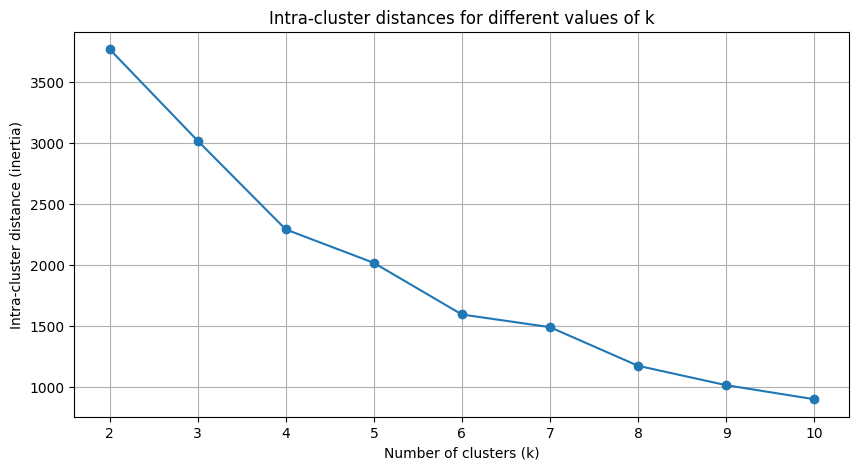

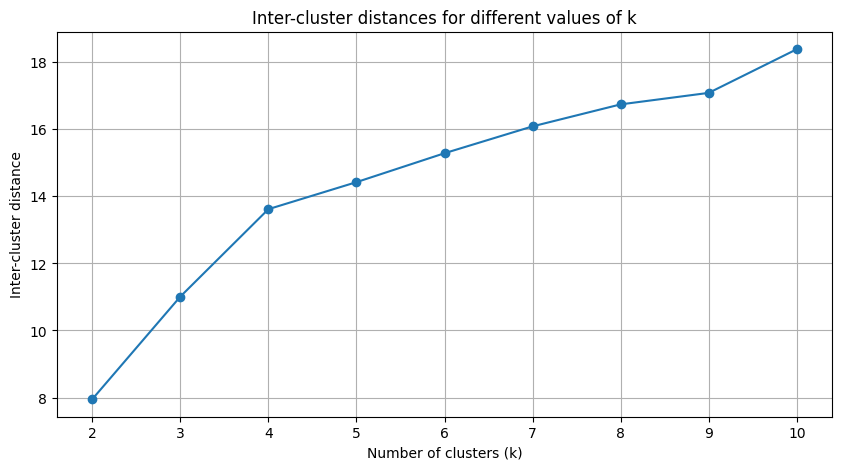

In [16]:
# Plotting the intra-cluster distances
plt.figure(figsize=(10, 5))
plt.plot(ks, intra_distances, marker='o')
plt.title('Intra-cluster distances for different values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Intra-cluster distance (inertia)')
plt.grid(True)
plt.show()

# Plotting the inter-cluster distances
plt.figure(figsize=(10, 5))
plt.plot(ks, inter_distances, marker='o')
plt.title('Inter-cluster distances for different values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inter-cluster distance')
plt.grid(True)
plt.show()

## Finding the optimal k

In [17]:
# Calculate the difference between subsequent elements in intra_distances
diff = np.diff(intra_distances)
# Calculate the difference between subsequent elements in diff
diff2 = np.diff(diff)
# The elbow is where the difference starts to increase
elbow = np.where(diff2 > 0)[0][0] + 1

### Plotting the elbow

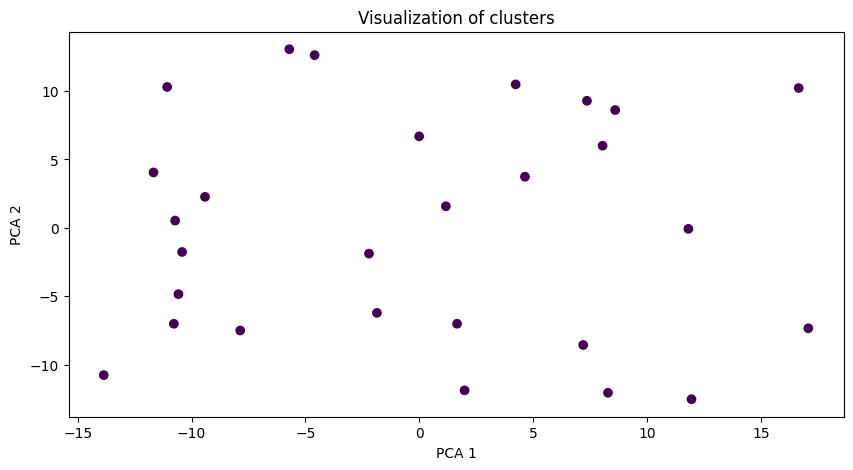

In [18]:
# Train a KMeans model with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=elbow)
kmeans_optimal.fit(sales_branch)

# Get the cluster assignments for each data point
cluster_assignments = kmeans_optimal.labels_

# Reduce the data to two dimensions using PCA
pca = PCA(n_components=2)
sales_branch_pca = pca.fit_transform(sales_branch)

# Create a scatter plot of the reduced data, colored by cluster assignment
plt.figure(figsize=(10, 5))
plt.scatter(sales_branch_pca[:, 0], sales_branch_pca[:, 1], c=cluster_assignments, cmap='viridis')
plt.title('Visualization of clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()